# Reinforcement Learning
Prof. Milica Gašić

### $n$-step return

In this notebook, we will implement offline versions for the $n$-step return.  
*Offline* means that the episodes are already generated and we update the value function by iterating over them.  


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

import rl_tests

#### $n$-step return

In the lecture the $n$-step return was defined as:
$$
g_{t:t+n} = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{n-1} r_{t+n} + \gamma^n V(s_{t+n})
$$

In the implementation we need to check for episode ends.  
To include episode ends, we can write the $n$-step return as:
$$
g_{t:t+n} = \begin{cases}
    \sum_{k=0}^{n-1} \gamma^k \, r_{t+k+1} + \gamma^n V(s_{t+n}) & \text{ if } t + n < T \\[5pt]
    \sum_{k=0}^{T-t-1} \gamma^k \, r_{t+k+1} & \text{ if } t + n \ge T
\end{cases}
$$
where $T$ is the last time step of the episode.

In [2]:
def n_step_return(v, episode, t, gamma, n):
    states = episode['states']
    rewards = episode['rewards']
    T = len(states) - 1

    g = 0.0  # n-step return

    #######################################################################
    # TODO: Calculate the n-step return for the time step t as described  #
    # above.                                                              #
    #######################################################################

    if t + n < T:
        g = (sum(gamma ** k * r for k, r in zip(range(n), rewards[t + 1:]))
             + gamma ** n * v[states[t + n]])
    else:
        g = sum(gamma ** k * r for k, r in zip(range(T - t), rewards[t + 1:]))

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

    return g

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [3]:
def test_n_step_return():
    episode = {
        'states': [10, 11, 12, 13, 14, 15, 16, 17],
        'rewards': [0.1, 0.2, -0.3, -0.4, 0.2, 0.6, -0.3, -0.2]
    }

    expected_gs = [
        [0.7225, 0.27, 0.2175],
        [0.11129375, 0.1006625, 0.97453125],
        [-0.164973909375, -0.3841830625, -0.08861375]
    ]

    for i, n in enumerate([1, 3, 10]):
        yield f'n = {n}'
        for t, expected_g in enumerate(expected_gs[i]):
            v = np.linspace(0.0, 1.0, 21)
            g = n_step_return(v, episode, t, 0.95, n)
            yield np.isclose(g,
                             expected_g), f'The return is incorrect (error = {abs(expected_g - g):.5f})'
            yield None


rl_tests.run_tests(test_n_step_return())

Testing n = 1...
3/3 tests passed!

Testing n = 3...
3/3 tests passed!

Testing n = 10...
3/3 tests passed!


#### Evaluation

If all tests passed, you can run the following code cells to recreate Figure 7.2 from lecture 6.

In [4]:
def random_walk_19():
    # Generate an episode for the 19-state random walk environment

    state = 10

    states = [state]
    rewards = [0.0]  # start with 0.0 for correct time steps

    terminated = False
    while not terminated:
        state += 1 if random.random() > 0.5 else -1
        if state == 20:
            reward = 1.0
            terminated = True
        elif state == 0:
            reward = -1.0
            terminated = True
        else:
            reward = 0
        states.append(state)
        rewards.append(reward)

    episode = {
        'states': states,
        'rewards': rewards,
        'terminated': terminated,
        'truncated': False
    }
    return episode

In [5]:
# Define the true values to compute the RMSE
v_true = np.linspace(-1.0, 1.0, 21)
v_true[[0, -1]] = 0
print(v_true)

[ 0.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  0. ]


In [6]:
# Generate random walks
num_runs = 10
num_episodes = 10
episodes = []
for _ in range(num_runs):
    run_episodes = []
    for _ in range(num_episodes):
        episode = random_walk_19()
        run_episodes.append(episode)
    episodes.append(run_episodes)

In [7]:
def evaluate(return_fn, episodes, alpha, **params):
    avg_rmse = 0.0
    for run_episodes in episodes:
        run_rmse = 0.0
        v = np.zeros(21)
        for episode in run_episodes:
            states = episode['states']
            T = len(states) - 1

            for t in range(T):
                s = states[t]
                g = return_fn(v, episode, t, **params)
                v[s] += alpha * (g - v[s])

            run_rmse += np.sqrt(np.mean((v - v_true) ** 2))
        run_rmse /= len(episodes)
        avg_rmse += run_rmse
    avg_rmse /= num_runs
    return avg_rmse

Evaluate $n$-step returns:

In [8]:
gamma = 1.0

alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ns = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

n_scores = np.zeros((len(ns), len(alphas)))

for i, n in enumerate(ns):
    for j, alpha in enumerate(alphas):
        n_scores[i, j] = evaluate(n_step_return, episodes, alpha=alpha, gamma=gamma, n=n)

Create the figure:

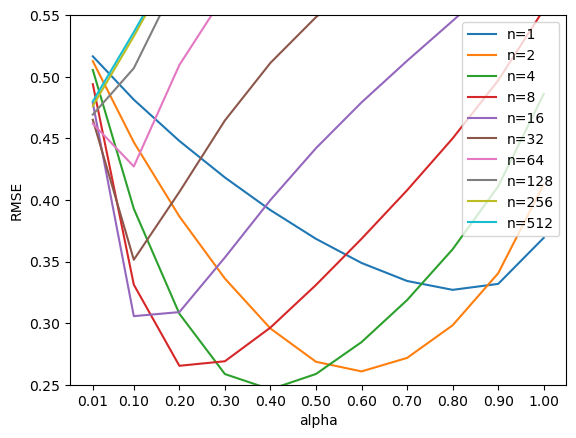

In [9]:
plt.ylabel('RMSE')
plt.ylim([0.25, 0.55])
plt.xlabel('alpha')
plt.xticks(alphas)
for i, n in enumerate(ns):
    plt.plot(alphas, n_scores[i], label=f'n={n}')
plt.legend()
plt.show()
